In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import tensorflow as tf
from keras import layers, models, losses
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("../../input/data.csv")

In [3]:
dataset.shape

(89, 1333)

In [4]:
def data_preprocessing_bin(dataset):

    X = dataset.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
    X.columns = X.columns.astype(int)
    X = X.values
    y = dataset['COVID-19_Status']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, X_test, y_train_encoded, y_test_encoded

In [5]:
X_train, X_test, y_train, y_test = data_preprocessing_bin(dataset)

In [6]:
latent_dim = 100
feature_dim = X_train.shape[1]
print(latent_dim, feature_dim)

100 1331


2/2 [==============================] - 0s 7ms/step
Epoch 0/10000 - Discriminator Loss: 18.977176040410995 - Generator Loss: 0.7031580805778503
2/2 [==============================] - 0s 0s/step
Epoch 10/10000 - Discriminator Loss: 18.97277557849884 - Generator Loss: 0.6087964177131653
2/2 [==============================] - 0s 0s/step
Epoch 20/10000 - Discriminator Loss: 19.03978157043457 - Generator Loss: 0.5518674850463867
2/2 [==============================] - 0s 0s/step
Epoch 30/10000 - Discriminator Loss: 18.96002107858658 - Generator Loss: 0.4803180992603302
2/2 [==============================] - 0s 0s/step
Epoch 40/10000 - Discriminator Loss: 19.05563920736313 - Generator Loss: 0.4324500262737274
2/2 [==============================] - 0s 0s/step
Epoch 50/10000 - Discriminator Loss: 19.07958036661148 - Generator Loss: 0.3622397184371948
2/2 [==============================] - 0s 16ms/step
Epoch 60/10000 - Discriminator Loss: 19.09443771839142 - Generator Loss: 0.3321916162967682
2/2

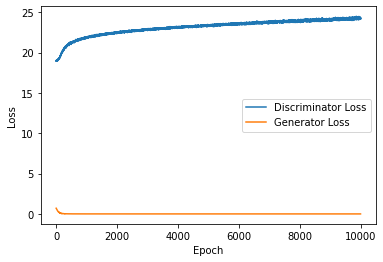

In [8]:
def build_generator(latent_dim):
    model = models.Sequential()
    
    # Fully-connected layer with 100 hidden units
    model.add(layers.Dense(100, input_dim=latent_dim))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization())

    # Three fully-connected layers with 64 hidden units each
    for _ in range(3):
        model.add(layers.Dense(64))
        model.add(layers.ReLU())
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(1331, activation='tanh'))

    return model

# Function to build the discriminator model
def build_discriminator(input_shape):
    model = models.Sequential()

    # Fully-connected layer with 1331 hidden units
    model.add(layers.Dense(1331, input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Two fully-connected layers with 64 hidden units each
    for _ in range(2):
        model.add(layers.Dense(64))
        model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Function to build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during GAN training

    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

# Train the GAN
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, real_data):
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        num_samples = real_data.shape[0]

        # Generate random noise as input to the generator
        noise = np.random.normal(0, 1, (num_samples, latent_dim))

        # Generate fake data using the generator
        generated_data = generator.predict(noise)

        # Combine real and fake data
        combined_data = np.concatenate([real_data, generated_data])

        # Labels for real and fake data
        labels_real = np.ones((num_samples, 1))
        labels_fake = np.zeros((num_samples, 1))

        # Randomly flip some labels for discriminator training stability
        labels_real += 0.05 * np.random.random(labels_real.shape)
        labels_fake -= 0.05 * np.random.random(labels_fake.shape)

        # Train the discriminator on real data
        d_loss_real = discriminator.train_on_batch(real_data, labels_real)

        # Train the discriminator on fake data
        d_loss_fake = discriminator.train_on_batch(generated_data, labels_fake)

        # Calculate total discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator to fool the discriminator
        noise = np.random.normal(0, 1, (num_samples, latent_dim))
        labels_gan = np.ones((num_samples, 1))

        # Update the generator via the combined model
        g_loss = gan.train_on_batch(noise, labels_gan)

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Print progress and save generated images at certain intervals
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Discriminator Loss: {d_loss} - Generator Loss: {g_loss}")

    # Plot the training losses
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((1331,))
gan = build_gan(generator, discriminator)

generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))

real_data = X_train

train_gan(generator, discriminator, gan, epochs=10000, batch_size=4, latent_dim=latent_dim, real_data=real_data)

In [9]:
def generate_synthetic_data(generator, latent_dim, num_samples):
    # Generate random noise as input to the generator
    noise = np.random.normal(0, 1, (num_samples, latent_dim))

    # Generate synthetic data using the generator
    synthetic_data = generator.predict(noise)

    return synthetic_data

In [10]:
latent_dim = 100  # Make sure to use the same latent_dim as used during training
num_synthetic_samples = 5  # Adjust the number of synthetic samples as needed

synthetic_data = generate_synthetic_data(generator, latent_dim, num_synthetic_samples)


1/1 [==============================] - 0s 12ms/step


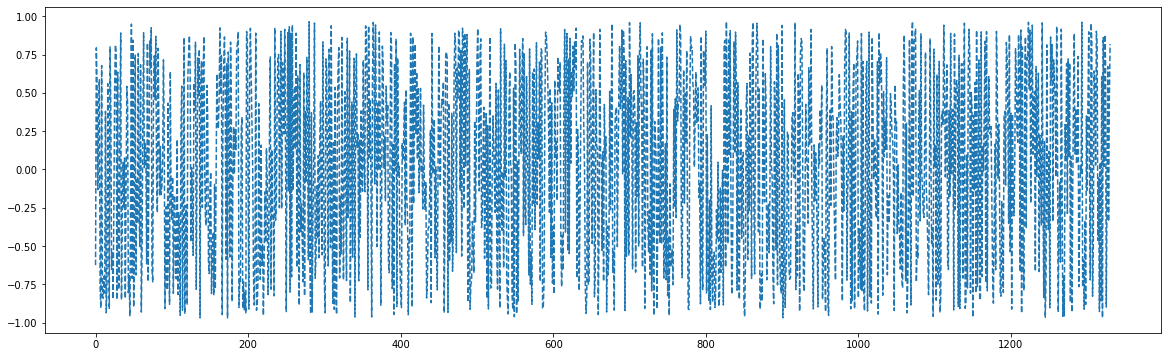

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(synthetic_data[0], linestyle='dashed')
# plt.plot(X_train[0], linestyle='dashed')
plt.show()

In [16]:
mean = X_train.mean()
std = X_train.std()
display(mean, std)

27.88265775846855

63.12374176875953

In [19]:
original_spectrum = (synthetic_data * std) + mean

In [20]:
original_spectrum

array([[-11.504885 ,  77.97068  ,  63.755882 , ...,   6.4516525,
         56.018612 ,  79.578636 ],
       [ 80.88552  , -34.45617  , -33.35534  , ..., -33.886604 ,
         90.44506  , -35.18318  ],
       [  1.7014122,  86.333046 ,  87.42239  , ...,  90.6138   ,
        -35.206787 ,  90.81744  ],
       [ -6.3960323,  82.88249  ,  68.14519  , ...,  49.874477 ,
        -17.28966  ,  87.83805  ],
       [ 66.055305 , -19.482378 , -16.20032  , ..., -32.019905 ,
         89.80717  , -33.594894 ]], dtype=float32)

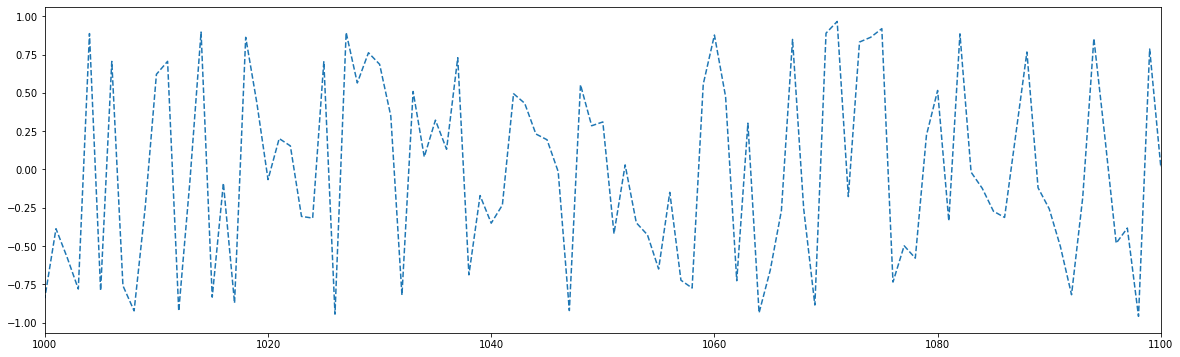

In [24]:
plt.figure(figsize=(20, 6))
plt.plot(synthetic_data[0], linestyle='dashed')
plt.xlim(1000, 1100)
# plt.plot(X_train[0], linestyle='dashed')
plt.show()

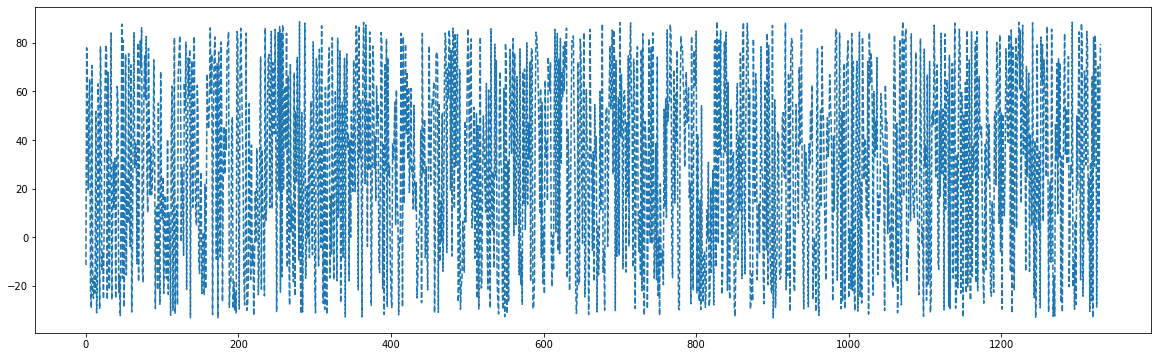

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(original_spectrum[0], linestyle='dashed')
# plt.plot(X_train[0], linestyle='dashed')
plt.show()

In [11]:
display(synthetic_data)

array([[-0.6239735 ,  0.7934894 ,  0.56830007, ..., -0.33950785,
         0.44572696,  0.8189625 ],
       [ 0.839666  , -0.9875655 , -0.9701263 , ..., -0.9785425 ,
         0.99110734, -0.99908274],
       [-0.41476068,  0.9259652 ,  0.9432225 , ...,  0.9937805 ,
        -0.99945664,  0.9970065 ],
       [-0.54303956,  0.8713019 ,  0.63783497, ...,  0.34839222,
        -0.71561533,  0.94980735],
       [ 0.60472727, -0.75035214, -0.6983581 , ..., -0.94897044,
         0.98100185, -0.97392124]], dtype=float32)